# Credit Card Fraud Detection

The raw file used for this project is on kaggle, click <a href="https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud">here</a> to go to the file location on kaggle.

In [61]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
import warnings
warnings.simplefilter(action="ignore")
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours
from imblearn.combine import SMOTETomek, SMOTEENN

In [2]:
with ZipFile("./creditcard.zip") as myzip:
    with myzip.open('creditcard.csv', "r") as myfile:
        data = pd.read_csv(myfile)

print(f"Shape of the data: {data.shape}")
data.head()

Shape of the data: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# data.info()

In [4]:
data.isna().sum().sum()

0

Two things could be deduced from the investigations made above:
<ol><li>All the columns of the data are numeric values</li><li>There is/are no null values in the data.</li></ol>
It seems someone someone has done the <b>dirty</b> job for us to have a <b>clean</b> data. 😄

In [5]:
data["Class"].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [6]:
data["Class"].value_counts(normalize=True)

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

In [7]:
# Check Class variables that have 0 value for Genuine transactions and 1 for Fraud

# fig, ax = plt.subplots(1, 1)
# ax.pie(data.Class.value_counts(),autopct='%1.1f%%', labels=['Genuine','Fraud'], colors=['yellowgreen','red'], startangle=90)
# plt.axis('equal')
# plt.xlabel('\nClass as pie chart', size=14)
# plt.title(f"Genuine: {data['Class'].value_counts().iloc[0]:,}\nFraud: {data['Class'].value_counts().iloc[1]:,}\n", size=12)
# plt.show()

In [8]:
# data["Time_Hr"] = data["Time"]/3600 # convert to hours
# fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, figsize=(10,6))
# ax1.hist(data.Time_Hr[data.Class==0],bins=48,color='g',alpha=0.5)
# ax1.set_title('Genuine')
# ax2.hist(data.Time_Hr[data.Class==1],bins=48,color='r',alpha=0.5)
# ax2.set_title('Fraud')
# plt.xlabel('Time (hrs)')
# plt.ylabel('# Transactions')
# plt.show()

In [9]:
# fig, axs = plt.subplots(2, 1, figsize=(16, 9))
# axs = axs.ravel()
# sns.kdeplot(data[data["Class"] == 0]["Time_Hr"], fill=True, ax=axs[0], color="g", label="Genuine")
# sns.kdeplot(data[data["Class"] == 1]["Time_Hr"], fill=True, ax=axs[1], color="r", label="Fraud")
# axs[0].set_title("Distribution of Genuine and Fraudulent Card Transactions\n")
# plt.show()

In [10]:
#let us check another feature Amount

# fig, (ax3,ax4) = plt.subplots(2, 1, figsize = (10,6), sharex = True)
# ax3.hist(data.Amount[data.Class==0], bins=50,color='g', alpha=0.5)
# ax3.set_yscale('log') # to see the tails
# ax3.set_title('Genuine') # to see the tails
# ax3.set_ylabel('# transactions')
# ax4.hist(data.Amount[data.Class==1],bins=50,color='r',alpha=0.5)
# ax4.set_yscale('log') # to see the tails
# ax4.set_title('Fraud') # to see the tails
# ax4.set_xlabel('Amount ($)')
# ax4.set_ylabel('# transactions')
# plt.show() 

In [11]:
df = data.copy()

In [12]:
#let us check correlations and shapes of those 28 principal components.
# Features V1, V2, ... V28 are the principal components obtained with PCA.

# import seaborn as sns
# import matplotlib.gridspec as gridspec
# gs = gridspec.GridSpec(28, 1)
# plt.figure(figsize=(10, 28*4))
# data = data.replace([np.inf, -np.inf], np.nan)
# for i, col in enumerate(data[data.iloc[:, 0:28].columns]):
#     ax5 = plt.subplot(gs[i])
#     sns.kdeplot(data[col][data.Class == 1], color='r', label="Fraud", fill=True, multiple="stack")
#     sns.kdeplot(data[col][data.Class == 0], color='g', label="Genuine", fill=True)
#     ax5.set_xlabel('')
#     plt.legend()
#     ax5.set_title('feature: ' + str(col))
# plt.show()

In [13]:
# drop_list = ['Time_Hr', 'V13' ,'V15', 'V22', 'V23', 'V25', 'V26', 'Time']
drop_list = ['V13' ,'V15', 'V22', 'V23', 'V25', 'V26', 'Time']

In [14]:
# A function to remove columns that might not be useful for prediction

def split_data(df, drop_list=None, test_size=0.2, stratify=True):
    if drop_list:
        df=df.drop(drop_list, axis=1)
    X=df.drop(['Class'], axis=1) 
    Y=df["Class"] 
    xData = X.values
    yData = Y.values
    xTrain, xTest, yTrain, yTest = train_test_split( 
            xData, yData, test_size=test_size, random_state=42, stratify=None if not stratify else yData)
    return xTrain, xTest, yTrain, yTest

In [62]:
# No Resampling
X_train_drop, X_test_drop, y_train_drop, y_test_drop = split_data(data, drop_list)
X_train, X_test, y_train, y_test = split_data(data)

# SMOTE Resampling
smote = SMOTE(random_state=42)
X_train_drop_smote, y_train_drop_smote = smote.fit_resample(X_train_drop, y_train_drop)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# ADASYN Resampling
ada = ADASYN(random_state=42)
X_train_drop_adasyn, y_train_drop_adasyn = smote.fit_resample(X_train_drop, y_train_drop)
X_train_adasyn, y_train_adasyn = smote.fit_resample(X_train, y_train)

# SMOTETomek
smotetomek = SMOTETomek(random_state=42, smote=SMOTE(random_state=42))
X_train_drop_smotetomek, y_train_drop_smotetomek = smotetomek.fit_resample(X_train_drop, y_train_drop)
X_train_smotetomek, y_train_smotetomek = smotetomek.fit_resample(X_train, y_train)

# SMOTEENN
smoteenn = SMOTEENN(random_state=42)
X_train_drop_smoteenn, y_train_drop_smoteenn = smoteenn.fit_resample(X_train_drop, y_train_drop)
X_train_smoteenn, y_train_smoteenn = smoteenn.fit_resample(X_train, y_train)

In [65]:
(X_train_drop_smotetomek.shape, y_train_drop_smotetomek.shape), (X_train_smotetomek.shape, y_train_smotetomek.shape)

(((454902, 23), (454902,)), ((453636, 30), (453636,)))

In [66]:
(X_train_drop_smoteenn.shape, y_train_drop_smoteenn.shape), (X_train_smoteenn.shape, y_train_smoteenn.shape)

(((454138, 23), (454138,)), ((427652, 30), (427652,)))

In [16]:
X_train.shape

(227845, 30)

## No Resampling

### Dropped Data

#### With Standard Scaler

In [17]:
lr = LogisticRegression(random_state=42, max_iter=100_000) # penalty", C, solver
params = {"penalty": ["l1", "l2", "elasticnet"], "C": np.linspace(.1, 2, 10)} #, "solver": ["lbfgs", "sag", "saga"]}
scoring = ["accuracy", "precision", "recall", "f1", "neg_log_loss"]
splits = range(5, 11)
# cv = StratifiedShuffleSplit(n_splits=split, test_size=.3, random_state=42)
cv = StratifiedShuffleSplit(test_size=.3, random_state=42)
# grid = GridSearchCV(lr, param_grid=params, cv=cv, n_jobs=-1, scoring=scoring)
grid = GridSearchCV(lr, param_grid=params, cv=cv, n_jobs=-1, scoring="accuracy")
clf = make_pipeline(StandardScaler(), grid)
clf.fit(X_train_drop, y_train_drop)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.3,
            train_size=None),
                              estimator=LogisticRegression(max_iter=100000,
                                                           random_state=42),
                              n_jobs=-1,
                              param_grid={'C': array([0.1       , 0.31111111, 0.52222222, 0.73333333, 0.94444444,
       1.15555556, 1.36666667, 1.57777778, 1.78888889, 2.        ]),
                                          'penalty': ['l1', 'l2',
                                                      'elasticnet']},
                              scoring='accuracy'))])

In [18]:
# res = {"Dropped": {}, "Intact": {}}
# for split in splits:
#     cv = StratifiedShuffleSplit(n_splits=split, test_size=.3, random_state=42)
#     grid = GridSearchCV(lr, param_grid=params, cv=cv, n_jobs=-1, scoring="accuracy") #, refit=False)
#     clf = make_pipeline(StandardScaler(), grid)
#     clf.fit(X_train_drop, y_train_drop)
#     print(clf.named_steps["gridsearchcv"].best_params_)
#     print(classification_report(y_test_drop, clf.predict(X_test_drop)))
#     print(ConfusionMatrixDisplay.from_estimator(clf, X_test_drop, y_test_drop))
#     print("\n\n")

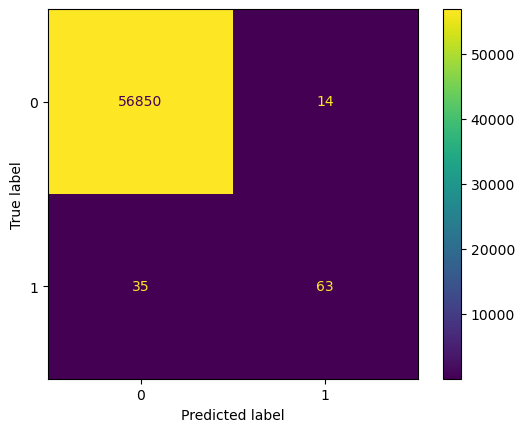

In [19]:
ConfusionMatrixDisplay.from_estimator(clf, X_test_drop, y_test_drop);

#### Without Standard Scaler

In [20]:
lr = LogisticRegression(random_state=42, max_iter=100_000)
params = {"penalty": ["l1", "l2", "elasticnet"], "C": np.linspace(.1, 2, 10)}
scoring = ["accuracy", "precision", "recall", "f1", "neg_log_loss"]
splits = range(5, 11)
cv = StratifiedShuffleSplit(test_size=.3, random_state=42)
grid = GridSearchCV(lr, param_grid=params, cv=cv, n_jobs=-1, scoring="accuracy")
grid.fit(X_train_drop, y_train_drop)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.3,
            train_size=None),
             estimator=LogisticRegression(max_iter=100000, random_state=42),
             n_jobs=-1,
             param_grid={'C': array([0.1       , 0.31111111, 0.52222222, 0.73333333, 0.94444444,
       1.15555556, 1.36666667, 1.57777778, 1.78888889, 2.        ]),
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='accuracy')

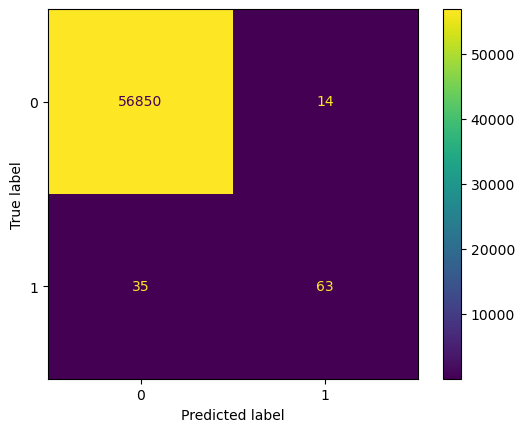

In [21]:
ConfusionMatrixDisplay.from_estimator(grid, X_test_drop, y_test_drop);

### Intact Data

#### With Standard Scaler

In [22]:
lr = LogisticRegression(random_state=42, max_iter=100_000)
params = {"penalty": ["l1", "l2", "elasticnet"], "C": np.linspace(.1, 2, 10)}
scoring = ["accuracy", "precision", "recall", "f1", "neg_log_loss"]
cv = StratifiedShuffleSplit(test_size=.3, random_state=42)
grid = GridSearchCV(lr, param_grid=params, cv=cv, n_jobs=-1, scoring="accuracy")
clf = make_pipeline(StandardScaler(), grid)
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.3,
            train_size=None),
                              estimator=LogisticRegression(max_iter=100000,
                                                           random_state=42),
                              n_jobs=-1,
                              param_grid={'C': array([0.1       , 0.31111111, 0.52222222, 0.73333333, 0.94444444,
       1.15555556, 1.36666667, 1.57777778, 1.78888889, 2.        ]),
                                          'penalty': ['l1', 'l2',
                                                      'elasticnet']},
                              scoring='accuracy'))])

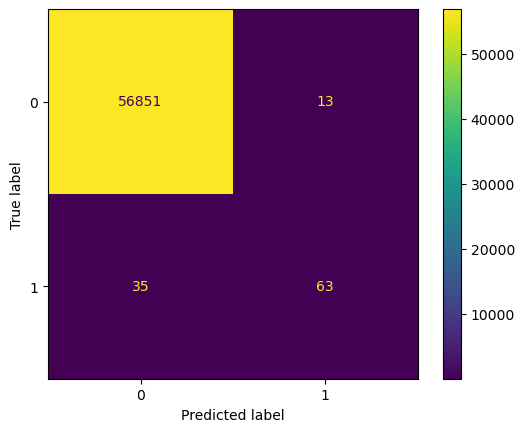

In [23]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test);

#### Without Standard Scaler

In [24]:
lr = LogisticRegression(random_state=42, max_iter=100_000)
params = {"penalty": ["l1", "l2", "elasticnet"], "C": np.linspace(.1, 2, 10)}
scoring = ["accuracy", "precision", "recall", "f1", "neg_log_loss"]
splits = range(5, 11)
cv = StratifiedShuffleSplit(test_size=.3, random_state=42)
grid = GridSearchCV(lr, param_grid=params, cv=cv, n_jobs=-1, scoring="accuracy")
grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.3,
            train_size=None),
             estimator=LogisticRegression(max_iter=100000, random_state=42),
             n_jobs=-1,
             param_grid={'C': array([0.1       , 0.31111111, 0.52222222, 0.73333333, 0.94444444,
       1.15555556, 1.36666667, 1.57777778, 1.78888889, 2.        ]),
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='accuracy')

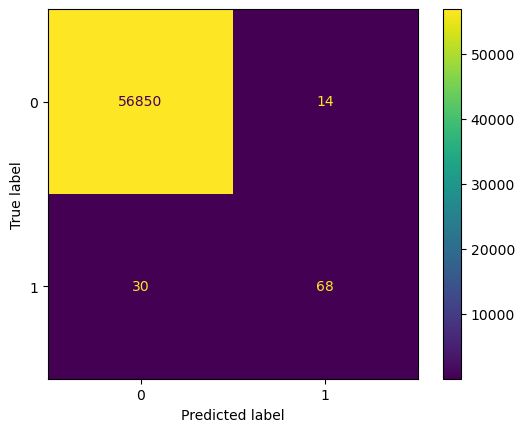

In [25]:
ConfusionMatrixDisplay.from_estimator(grid, X_test, y_test);

## SMOTE

### Dropped Data

#### With Standard Scaler

In [29]:
lr = LogisticRegression(random_state=42, max_iter=100_000)
params = {"penalty": ["l1", "l2", "elasticnet"], "C": np.linspace(.1, 2, 10)}
scoring = ["accuracy", "precision", "recall", "f1", "neg_log_loss"]
splits = range(5, 11)
cv = StratifiedShuffleSplit(test_size=.3, random_state=42)
grid = GridSearchCV(lr, param_grid=params, cv=cv, n_jobs=-1, scoring="accuracy")
clf = make_pipeline(StandardScaler(), grid)
clf.fit(X_train_drop_smote, y_train_drop_smote)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.3,
            train_size=None),
                              estimator=LogisticRegression(max_iter=100000,
                                                           random_state=42),
                              n_jobs=-1,
                              param_grid={'C': array([0.1       , 0.31111111, 0.52222222, 0.73333333, 0.94444444,
       1.15555556, 1.36666667, 1.57777778, 1.78888889, 2.        ]),
                                          'penalty': ['l1', 'l2',
                                                      'elasticnet']},
                              scoring='accuracy'))])

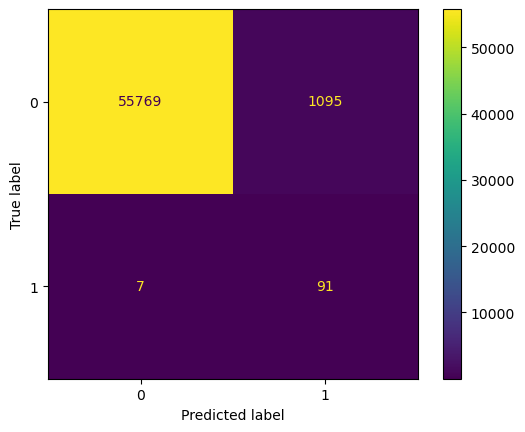

In [30]:
ConfusionMatrixDisplay.from_estimator(clf, X_test_drop, y_test_drop);

#### Without Standard Scaler

In [31]:
lr = LogisticRegression(random_state=42, max_iter=100_000)
params = {"penalty": ["l1", "l2", "elasticnet"], "C": np.linspace(.1, 2, 10)}
scoring = ["accuracy", "precision", "recall", "f1", "neg_log_loss"]
splits = range(5, 11)
cv = StratifiedShuffleSplit(test_size=.3, random_state=42)
grid = GridSearchCV(lr, param_grid=params, cv=cv, n_jobs=-1, scoring="accuracy")
grid.fit(X_train_drop_smote, y_train_drop_smote)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.3,
            train_size=None),
             estimator=LogisticRegression(max_iter=100000, random_state=42),
             n_jobs=-1,
             param_grid={'C': array([0.1       , 0.31111111, 0.52222222, 0.73333333, 0.94444444,
       1.15555556, 1.36666667, 1.57777778, 1.78888889, 2.        ]),
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='accuracy')

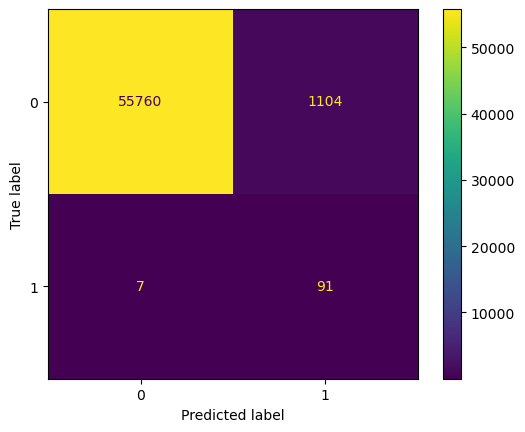

In [32]:
ConfusionMatrixDisplay.from_estimator(grid, X_test_drop, y_test_drop);

### Intact Data

#### With Standard Scaler

In [34]:
lr = LogisticRegression(random_state=42, max_iter=100_000)
params = {"penalty": ["l1", "l2", "elasticnet"], "C": np.linspace(.1, 2, 10)}
scoring = ["accuracy", "precision", "recall", "f1", "neg_log_loss"]
cv = StratifiedShuffleSplit(test_size=.3, random_state=42)
grid = GridSearchCV(lr, param_grid=params, cv=cv, n_jobs=-1, scoring="accuracy")
clf = make_pipeline(StandardScaler(), grid)
clf.fit(X_train_smote, y_train_smote)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.3,
            train_size=None),
                              estimator=LogisticRegression(max_iter=100000,
                                                           random_state=42),
                              n_jobs=-1,
                              param_grid={'C': array([0.1       , 0.31111111, 0.52222222, 0.73333333, 0.94444444,
       1.15555556, 1.36666667, 1.57777778, 1.78888889, 2.        ]),
                                          'penalty': ['l1', 'l2',
                                                      'elasticnet']},
                              scoring='accuracy'))])

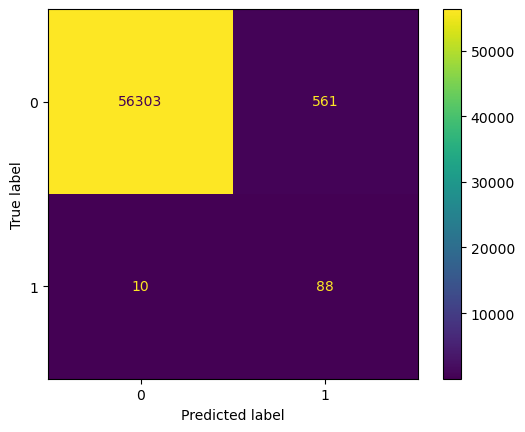

In [35]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test);

#### Without Standard Scaler

In [36]:
lr = LogisticRegression(random_state=42, max_iter=100_000)
params = {"penalty": ["l1", "l2", "elasticnet"], "C": np.linspace(.1, 2, 10)}
scoring = ["accuracy", "precision", "recall", "f1", "neg_log_loss"]
splits = range(5, 11)
cv = StratifiedShuffleSplit(test_size=.3, random_state=42)
grid = GridSearchCV(lr, param_grid=params, cv=cv, n_jobs=-1, scoring="accuracy")
grid.fit(X_train_smote, y_train_smote)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.3,
            train_size=None),
             estimator=LogisticRegression(max_iter=100000, random_state=42),
             n_jobs=-1,
             param_grid={'C': array([0.1       , 0.31111111, 0.52222222, 0.73333333, 0.94444444,
       1.15555556, 1.36666667, 1.57777778, 1.78888889, 2.        ]),
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='accuracy')

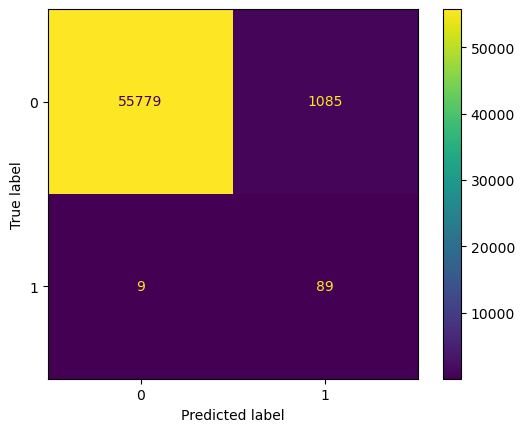

In [37]:
ConfusionMatrixDisplay.from_estimator(grid, X_test, y_test);

In [38]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [41]:
df[["Class", "Amount"]].groupby("Class").mean()

,Amount
Class,
0,88.291022
1,122.211321


In [44]:
def money_lost(FP, FN):
    return (FP * 88.291022 + FN * 122.211321) * -1

In [45]:
money_lost(3, 22)

-2953.522128

In [46]:
money_lost(2, 36)

-4576.1896

In [47]:
money_lost(13, 35)

-5425.179521

In [48]:
money_lost(14, 30)

-4902.413938

In [49]:
money_lost(9, 44)

-6171.917322

## ADASYN

### Dropped Data

#### With Standard Scaler

In [51]:
lr = LogisticRegression(random_state=42, max_iter=100_000)
params = {"penalty": ["l1", "l2", "elasticnet"], "C": np.linspace(.1, 2, 10)}
scoring = ["accuracy", "precision", "recall", "f1", "neg_log_loss"]
splits = range(5, 11)
cv = StratifiedShuffleSplit(test_size=.3, random_state=42)
grid = GridSearchCV(lr, param_grid=params, cv=cv, n_jobs=-1, scoring="accuracy")
clf = make_pipeline(StandardScaler(), grid)
clf.fit(X_train_drop_adasyn, y_train_drop_adasyn)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.3,
            train_size=None),
                              estimator=LogisticRegression(max_iter=100000,
                                                           random_state=42),
                              n_jobs=-1,
                              param_grid={'C': array([0.1       , 0.31111111, 0.52222222, 0.73333333, 0.94444444,
       1.15555556, 1.36666667, 1.57777778, 1.78888889, 2.        ]),
                                          'penalty': ['l1', 'l2',
                                                      'elasticnet']},
                              scoring='accuracy'))])

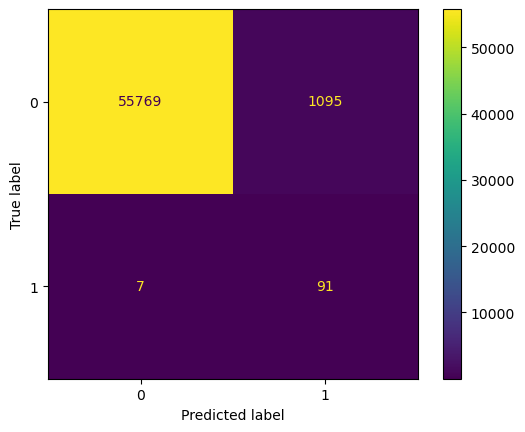

In [52]:
ConfusionMatrixDisplay.from_estimator(clf, X_test_drop, y_test_drop);

#### Without Standard Scaler

In [53]:
lr = LogisticRegression(random_state=42, max_iter=100_000)
params = {"penalty": ["l1", "l2", "elasticnet"], "C": np.linspace(.1, 2, 10)}
scoring = ["accuracy", "precision", "recall", "f1", "neg_log_loss"]
splits = range(5, 11)
cv = StratifiedShuffleSplit(test_size=.3, random_state=42)
grid = GridSearchCV(lr, param_grid=params, cv=cv, n_jobs=-1, scoring="accuracy")
grid.fit(X_train_drop_adasyn, y_train_drop_adasyn)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.3,
            train_size=None),
             estimator=LogisticRegression(max_iter=100000, random_state=42),
             n_jobs=-1,
             param_grid={'C': array([0.1       , 0.31111111, 0.52222222, 0.73333333, 0.94444444,
       1.15555556, 1.36666667, 1.57777778, 1.78888889, 2.        ]),
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='accuracy')

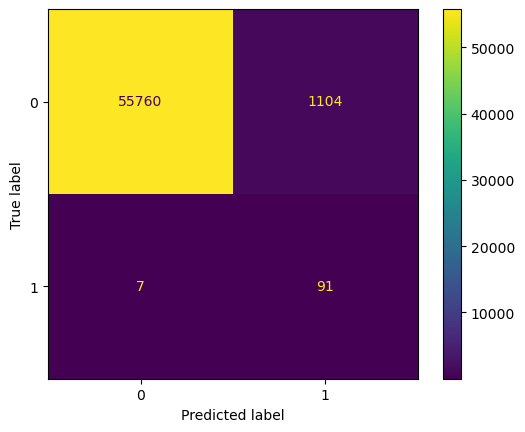

In [54]:
ConfusionMatrixDisplay.from_estimator(grid, X_test_drop, y_test_drop);

### Intact Data

#### With Standard Scaler

In [55]:
lr = LogisticRegression(random_state=42, max_iter=100_000)
params = {"penalty": ["l1", "l2", "elasticnet"], "C": np.linspace(.1, 2, 10)}
scoring = ["accuracy", "precision", "recall", "f1", "neg_log_loss"]
cv = StratifiedShuffleSplit(test_size=.3, random_state=42)
grid = GridSearchCV(lr, param_grid=params, cv=cv, n_jobs=-1, scoring="accuracy")
clf = make_pipeline(StandardScaler(), grid)
clf.fit(X_train_adasyn, y_train_adasyn)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.3,
            train_size=None),
                              estimator=LogisticRegression(max_iter=100000,
                                                           random_state=42),
                              n_jobs=-1,
                              param_grid={'C': array([0.1       , 0.31111111, 0.52222222, 0.73333333, 0.94444444,
       1.15555556, 1.36666667, 1.57777778, 1.78888889, 2.        ]),
                                          'penalty': ['l1', 'l2',
                                                      'elasticnet']},
                              scoring='accuracy'))])

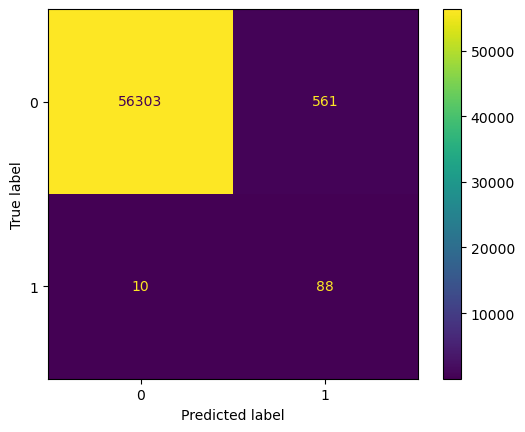

In [56]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test);

#### Without Standard Scaler

In [57]:
lr = LogisticRegression(random_state=42, max_iter=100_000)
params = {"penalty": ["l1", "l2", "elasticnet"], "C": np.linspace(.1, 2, 10)}
scoring = ["accuracy", "precision", "recall", "f1", "neg_log_loss"]
splits = range(5, 11)
cv = StratifiedShuffleSplit(test_size=.3, random_state=42)
grid = GridSearchCV(lr, param_grid=params, cv=cv, n_jobs=-1, scoring="accuracy")
grid.fit(X_train_adasyn, y_train_adasyn)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.3,
            train_size=None),
             estimator=LogisticRegression(max_iter=100000, random_state=42),
             n_jobs=-1,
             param_grid={'C': array([0.1       , 0.31111111, 0.52222222, 0.73333333, 0.94444444,
       1.15555556, 1.36666667, 1.57777778, 1.78888889, 2.        ]),
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='accuracy')

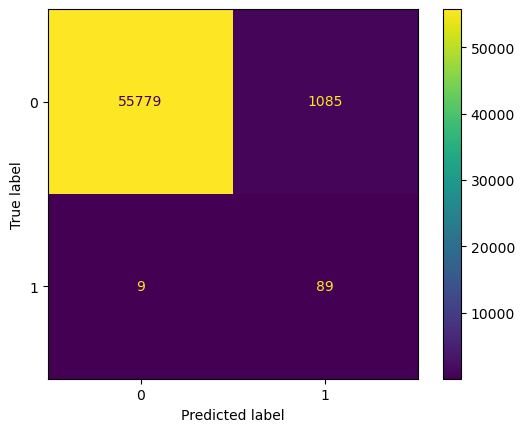

In [58]:
ConfusionMatrixDisplay.from_estimator(grid, X_test, y_test);

## SMOTETomek

### Dropped Data

#### With Standard Scaler

In [67]:
lr = LogisticRegression(random_state=42, max_iter=100_000)
params = {"penalty": ["l1", "l2", "elasticnet"], "C": np.linspace(.1, 2, 10)}
scoring = ["accuracy", "precision", "recall", "f1", "neg_log_loss"]
splits = range(5, 11)
cv = StratifiedShuffleSplit(test_size=.3, random_state=42)
grid = GridSearchCV(lr, param_grid=params, cv=cv, n_jobs=-1, scoring="accuracy")
clf = make_pipeline(StandardScaler(), grid)
clf.fit(X_train_drop_smotetomek, y_train_drop_smotetomek)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.3,
            train_size=None),
                              estimator=LogisticRegression(max_iter=100000,
                                                           random_state=42),
                              n_jobs=-1,
                              param_grid={'C': array([0.1       , 0.31111111, 0.52222222, 0.73333333, 0.94444444,
       1.15555556, 1.36666667, 1.57777778, 1.78888889, 2.        ]),
                                          'penalty': ['l1', 'l2',
                                                      'elasticnet']},
                              scoring='accuracy'))])

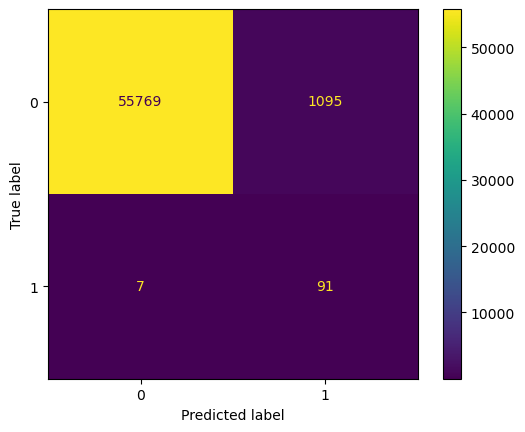

In [68]:
ConfusionMatrixDisplay.from_estimator(clf, X_test_drop, y_test_drop);

#### Without Standard Scaler

In [69]:
lr = LogisticRegression(random_state=42, max_iter=100_000)
params = {"penalty": ["l1", "l2", "elasticnet"], "C": np.linspace(.1, 2, 10)}
scoring = ["accuracy", "precision", "recall", "f1", "neg_log_loss"]
splits = range(5, 11)
cv = StratifiedShuffleSplit(test_size=.3, random_state=42)
grid = GridSearchCV(lr, param_grid=params, cv=cv, n_jobs=-1, scoring="accuracy")
grid.fit(X_train_drop_smotetomek, y_train_drop_smotetomek)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.3,
            train_size=None),
             estimator=LogisticRegression(max_iter=100000, random_state=42),
             n_jobs=-1,
             param_grid={'C': array([0.1       , 0.31111111, 0.52222222, 0.73333333, 0.94444444,
       1.15555556, 1.36666667, 1.57777778, 1.78888889, 2.        ]),
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='accuracy')

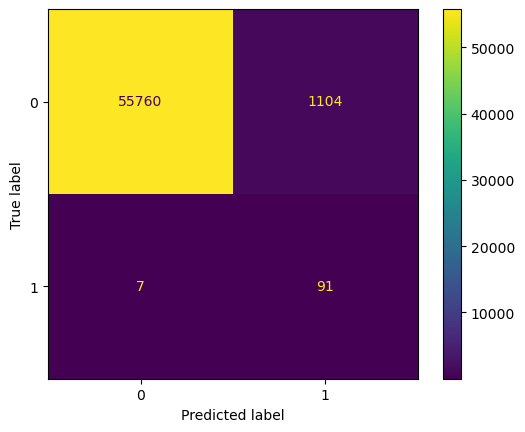

In [70]:
ConfusionMatrixDisplay.from_estimator(grid, X_test_drop, y_test_drop);

### Intact Data

#### With Standard Scaler

In [71]:
lr = LogisticRegression(random_state=42, max_iter=100_000)
params = {"penalty": ["l1", "l2", "elasticnet"], "C": np.linspace(.1, 2, 10)}
scoring = ["accuracy", "precision", "recall", "f1", "neg_log_loss"]
cv = StratifiedShuffleSplit(test_size=.3, random_state=42)
grid = GridSearchCV(lr, param_grid=params, cv=cv, n_jobs=-1, scoring="accuracy")
clf = make_pipeline(StandardScaler(), grid)
clf.fit(X_train_smotetomek, y_train_smotetomek)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.3,
            train_size=None),
                              estimator=LogisticRegression(max_iter=100000,
                                                           random_state=42),
                              n_jobs=-1,
                              param_grid={'C': array([0.1       , 0.31111111, 0.52222222, 0.73333333, 0.94444444,
       1.15555556, 1.36666667, 1.57777778, 1.78888889, 2.        ]),
                                          'penalty': ['l1', 'l2',
                                                      'elasticnet']},
                              scoring='accuracy'))])

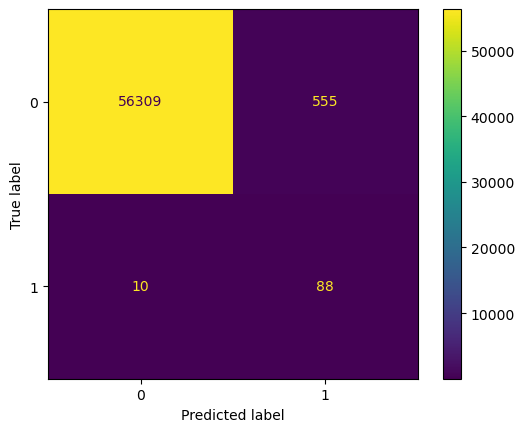

In [72]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test);

#### Without Standard Scaler

In [73]:
lr = LogisticRegression(random_state=42, max_iter=100_000)
params = {"penalty": ["l1", "l2", "elasticnet"], "C": np.linspace(.1, 2, 10)}
scoring = ["accuracy", "precision", "recall", "f1", "neg_log_loss"]
splits = range(5, 11)
cv = StratifiedShuffleSplit(test_size=.3, random_state=42)
grid = GridSearchCV(lr, param_grid=params, cv=cv, n_jobs=-1, scoring="accuracy")
grid.fit(X_train_smotetomek, y_train_smotetomek)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.3,
            train_size=None),
             estimator=LogisticRegression(max_iter=100000, random_state=42),
             n_jobs=-1,
             param_grid={'C': array([0.1       , 0.31111111, 0.52222222, 0.73333333, 0.94444444,
       1.15555556, 1.36666667, 1.57777778, 1.78888889, 2.        ]),
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='accuracy')

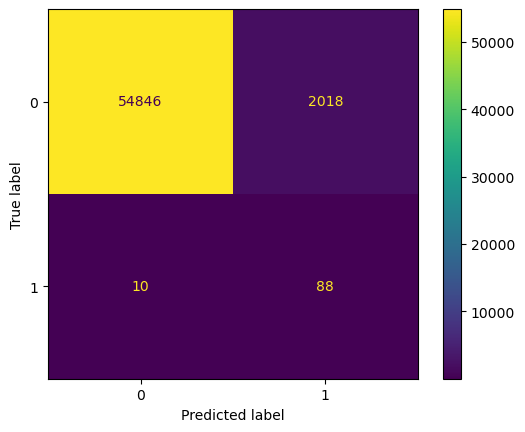

In [74]:
ConfusionMatrixDisplay.from_estimator(grid, X_test, y_test);

## SMOTEENN

### Dropped Data

#### With Standard Scaler

In [75]:
lr = LogisticRegression(random_state=42, max_iter=100_000)
params = {"penalty": ["l1", "l2", "elasticnet"], "C": np.linspace(.1, 2, 10)}
scoring = ["accuracy", "precision", "recall", "f1", "neg_log_loss"]
splits = range(5, 11)
cv = StratifiedShuffleSplit(test_size=.3, random_state=42)
grid = GridSearchCV(lr, param_grid=params, cv=cv, n_jobs=-1, scoring="accuracy")
clf = make_pipeline(StandardScaler(), grid)
clf.fit(X_train_drop_smoteenn, y_train_drop_smoteenn)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.3,
            train_size=None),
                              estimator=LogisticRegression(max_iter=100000,
                                                           random_state=42),
                              n_jobs=-1,
                              param_grid={'C': array([0.1       , 0.31111111, 0.52222222, 0.73333333, 0.94444444,
       1.15555556, 1.36666667, 1.57777778, 1.78888889, 2.        ]),
                                          'penalty': ['l1', 'l2',
                                                      'elasticnet']},
                              scoring='accuracy'))])

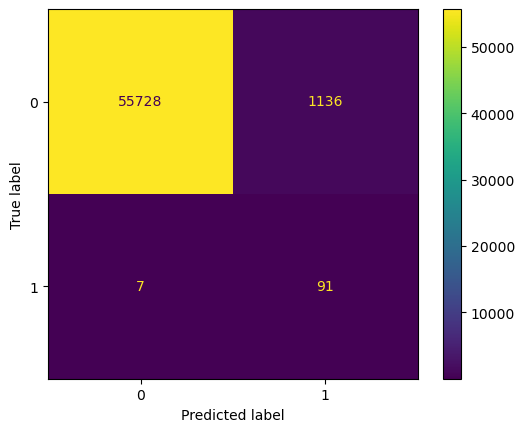

In [76]:
ConfusionMatrixDisplay.from_estimator(clf, X_test_drop, y_test_drop);

#### Without Standard Scaler

In [77]:
lr = LogisticRegression(random_state=42, max_iter=100_000)
params = {"penalty": ["l1", "l2", "elasticnet"], "C": np.linspace(.1, 2, 10)}
scoring = ["accuracy", "precision", "recall", "f1", "neg_log_loss"]
splits = range(5, 11)
cv = StratifiedShuffleSplit(test_size=.3, random_state=42)
grid = GridSearchCV(lr, param_grid=params, cv=cv, n_jobs=-1, scoring="accuracy")
grid.fit(X_train_drop_smoteenn, y_train_drop_smoteenn)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.3,
            train_size=None),
             estimator=LogisticRegression(max_iter=100000, random_state=42),
             n_jobs=-1,
             param_grid={'C': array([0.1       , 0.31111111, 0.52222222, 0.73333333, 0.94444444,
       1.15555556, 1.36666667, 1.57777778, 1.78888889, 2.        ]),
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='accuracy')

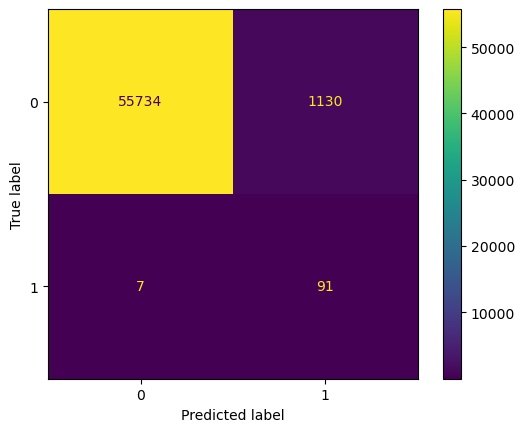

In [78]:
ConfusionMatrixDisplay.from_estimator(grid, X_test_drop, y_test_drop);

### Intact Data

#### With Standard Scaler

In [79]:
lr = LogisticRegression(random_state=42, max_iter=100_000)
params = {"penalty": ["l1", "l2", "elasticnet"], "C": np.linspace(.1, 2, 10)}
scoring = ["accuracy", "precision", "recall", "f1", "neg_log_loss"]
cv = StratifiedShuffleSplit(test_size=.3, random_state=42)
grid = GridSearchCV(lr, param_grid=params, cv=cv, n_jobs=-1, scoring="accuracy")
clf = make_pipeline(StandardScaler(), grid)
clf.fit(X_train_smoteenn, y_train_smoteenn)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.3,
            train_size=None),
                              estimator=LogisticRegression(max_iter=100000,
                                                           random_state=42),
                              n_jobs=-1,
                              param_grid={'C': array([0.1       , 0.31111111, 0.52222222, 0.73333333, 0.94444444,
       1.15555556, 1.36666667, 1.57777778, 1.78888889, 2.        ]),
                                          'penalty': ['l1', 'l2',
                                                      'elasticnet']},
                              scoring='accuracy'))])

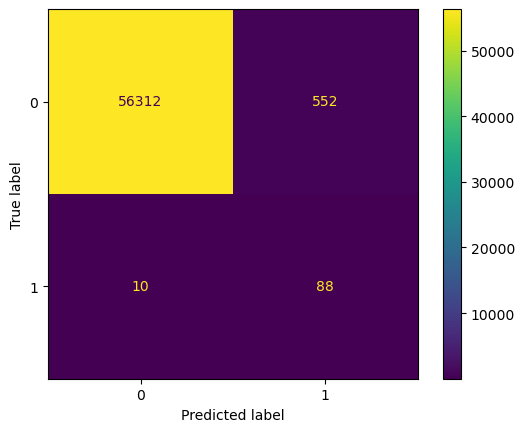

In [80]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test);

#### Without Standard Scaler

In [81]:
lr = LogisticRegression(random_state=42, max_iter=100_000)
params = {"penalty": ["l1", "l2", "elasticnet"], "C": np.linspace(.1, 2, 10)}
scoring = ["accuracy", "precision", "recall", "f1", "neg_log_loss"]
splits = range(5, 11)
cv = StratifiedShuffleSplit(test_size=.3, random_state=42)
grid = GridSearchCV(lr, param_grid=params, cv=cv, n_jobs=-1, scoring="accuracy")
grid.fit(X_train_smoteenn, y_train_smoteenn)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.3,
            train_size=None),
             estimator=LogisticRegression(max_iter=100000, random_state=42),
             n_jobs=-1,
             param_grid={'C': array([0.1       , 0.31111111, 0.52222222, 0.73333333, 0.94444444,
       1.15555556, 1.36666667, 1.57777778, 1.78888889, 2.        ]),
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='accuracy')

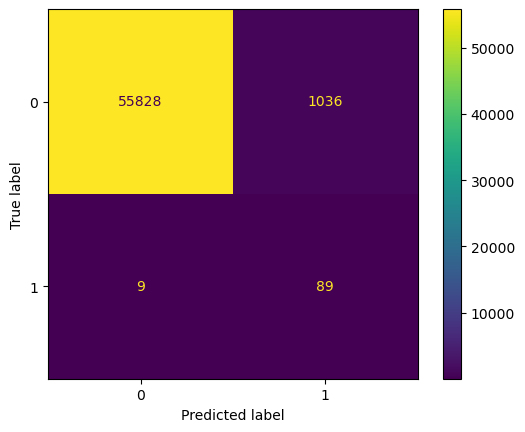

In [82]:
ConfusionMatrixDisplay.from_estimator(grid, X_test, y_test);